<a href="https://colab.research.google.com/github/Adhishreya/Liver-Disease-Prediction/blob/main/Final_Liver_disease_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Liver Disease Detection
**The attributes**
* Age Age of the patient
* Gender Gender of the patient
* TB Total Bilirubin
* DB Direct Bilirubin
* Alkphos Alkaline Phosphotase
* Sgpt Alamine Aminotransferase
* Sgot Aspartate Aminotransferase
* TP Total Protiens
* ALB Albumin
* A/G Ratio Albumin and Globulin Ratio
* Selector field used to split the data into two sets (labeled by the experts)

In [52]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
from sklearn.neighbors import KNeighborsClassifier
from xgboost import  XGBClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,classification_report, roc_auc_score, roc_curve,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [53]:
data=pd.read_csv('/content/indian_liver_patient.csv')
data.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1



# Exploratory data analysis

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns, to spot anomalies, to test hypothesis and
to check assumptions with the help of summary statistics and graphical representations.

In [54]:
columns=data.columns
#providing information about various data-types and the pesence of null values
# age 583 non-null implies out of 583
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


## cleaning dataset



In [55]:
data['Gender']=data['Gender'].replace({'Male':0.0,'Female':1.0})
data=data.dropna(axis=0)
data['Dataset']=data['Dataset'].replace(2,0)
# data=data.drop(['Albumin','Albumin_and_Globulin_Ratio'],axis=1)

In [56]:
data['Dataset'].value_counts()
# 1-positive

1    414
0    165
Name: Dataset, dtype: int64

positive samples: 71.5%
Negative Samples: 28.5%


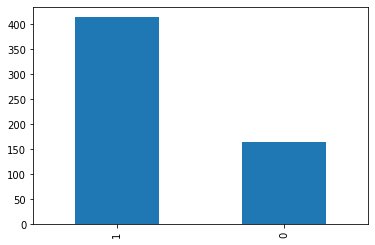

In [57]:
#Data is unbalanced
data['Dataset'].value_counts().plot.bar()
cnt=data['Dataset'].value_counts(normalize=True)
print('positive samples: {}%\nNegative Samples: {}%'.format(round(cnt[1]*100,2),round(cnt[0]*100,2)))

It is evident that the data set is quite unbalanced.The majority
class occupies nearly 72% of the data while the minority class occupies 28% of the
training data

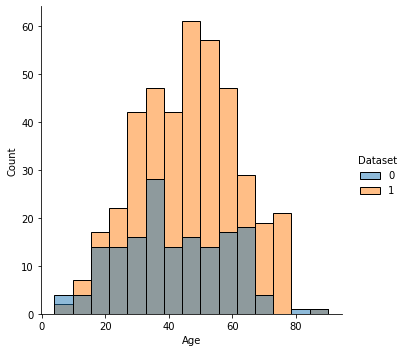

In [58]:
sns.displot(data=data,x='Age',hue='Dataset')

We can analyse form the age wise distribution of the disease in individuals.We observe a surge in trend of affected individuals in the ages 40-60.This may
be attributed due to various lifestyle changes in individuals.

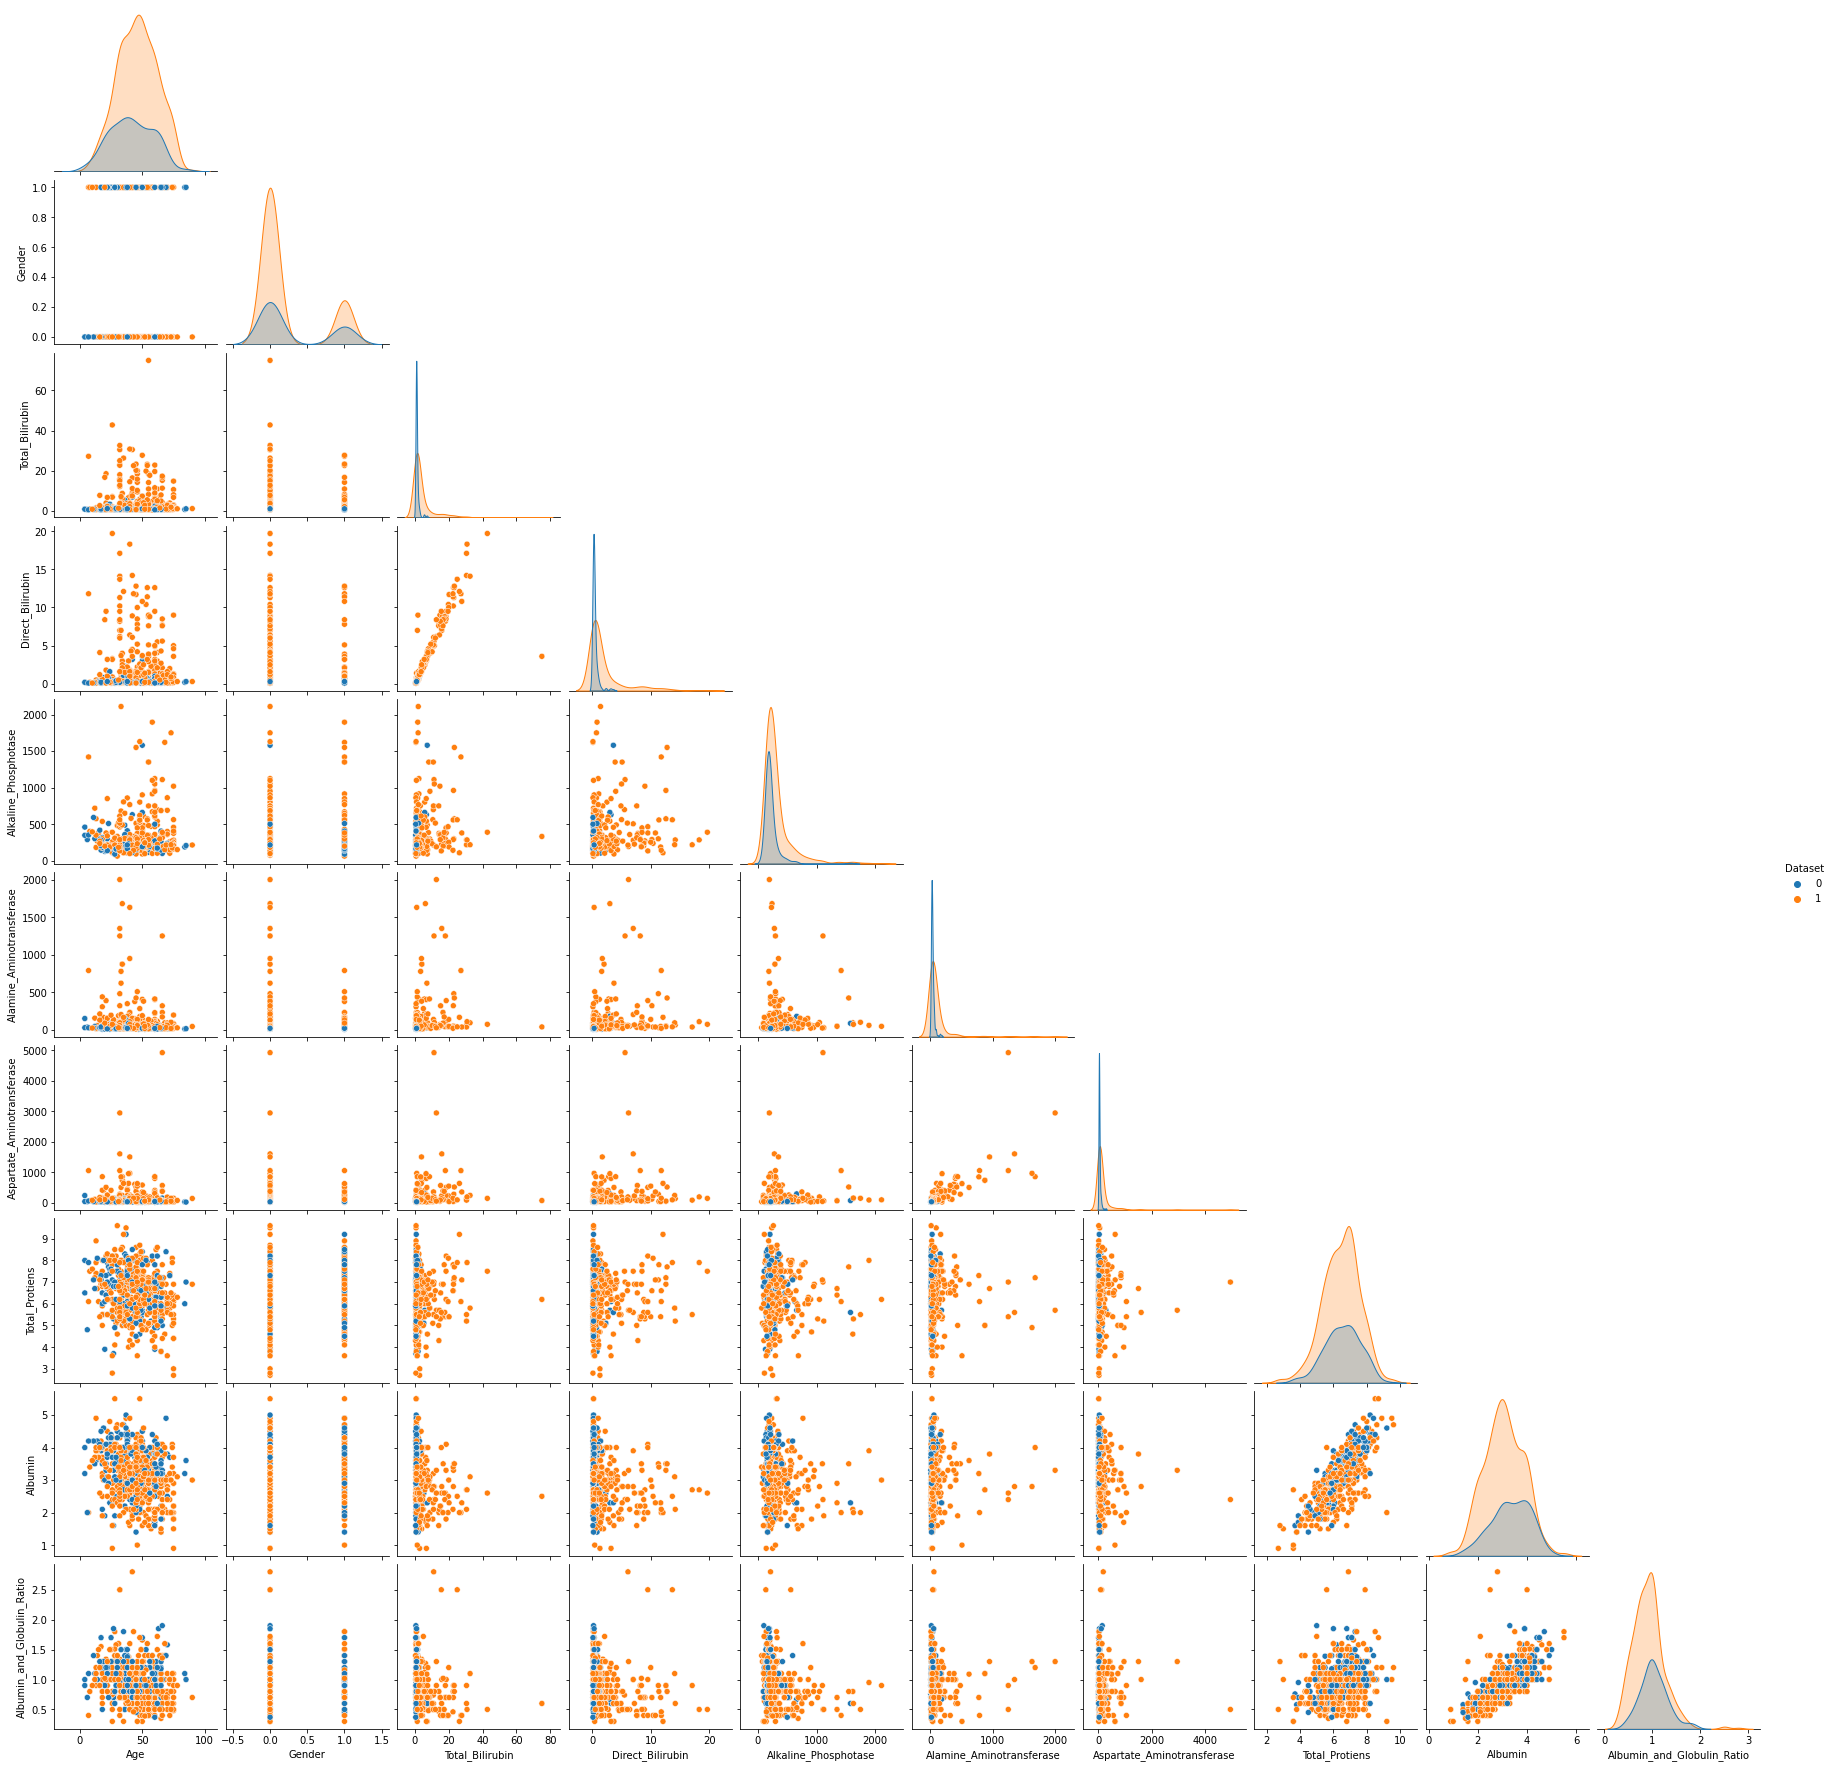

In [59]:
#pairplot
pp=sns.pairplot(data,hue='Dataset',corner=True)

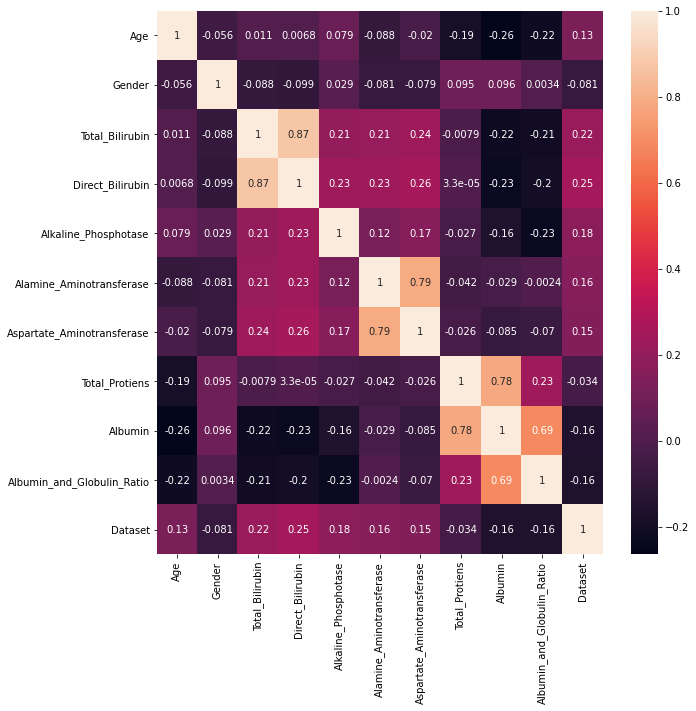

In [60]:
plt.figure(figsize=(10,10))
hm=sns.heatmap(data.corr(),annot=True)

In [61]:
data.describe()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
count,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000
mean,44.782383,0.241796,3.315371,1.494128,291.366149,81.126079,110.414508,6.481693,3.138515,0.947064,0.715026
std,16.221786,0.428542,6.227716,2.816499,243.561863,183.182845,289.850034,1.084641,0.794435,0.319592,0.451792
min,4.000000,0.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,0.000000
25%,33.000000,0.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,0.000000
50%,45.000000,0.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,0.000000,2.600000,1.300000,298.000000,61.000000,87.000000,7.200000,3.800000,1.100000,1.000000
max,90.000000,1.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,1.000000


<Figure size 720x720 with 0 Axes>

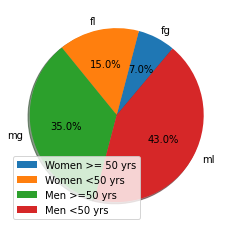

In [62]:
fg=data[(data['Gender']==1) & (data['Dataset']==1 )& (data['Age']>=50)].dropna().shape[0]
fl=data[(data['Gender']==1) & (data['Dataset']==1 )& (data['Age']<50)].dropna().shape[0]

mg=data[(data['Gender']==0) & (data['Dataset']==1 )& (data['Age']>=50)].dropna().shape[0]

ml=data[(data['Gender']==0) & (data['Dataset']==1 )& (data['Age']<50)].dropna().shape[0]

label=['fg','fl','mg','ml']
plt.figure(figsize=(10,10))
sizes=[fg,fl,mg,ml]
fig,ax1=plt.subplots()
ax1.pie(sizes,labels=label,shadow=True,startangle=50, autopct='%1.1f%%')
plt.legend(["Women >= 50 yrs","Women <50 yrs","Men >=50 yrs","Men <50 yrs"],loc="best")
plt.show()

A pie chart depicts the gender wise and age wise distribution of the liver disease.It is clear that the population above the age of 50 occupies
majority of the area of the chart

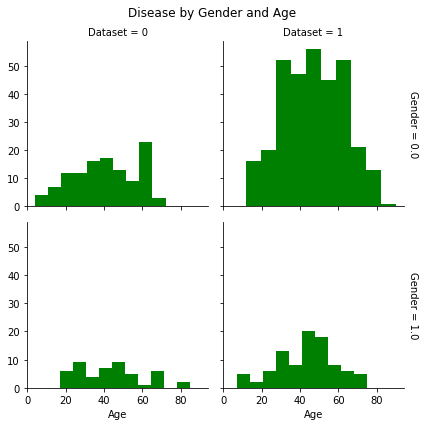

In [63]:
g = sns.FacetGrid(data, col="Dataset", row="Gender", margin_titles=True)
g.map(plt.hist, "Age", color="g")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Disease by Gender and Age');

# splitting to training and testing sets

In [64]:
X=data[data.columns[:-1]]
Y=data['Dataset']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=27)
scaler=StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

## balancing the data

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


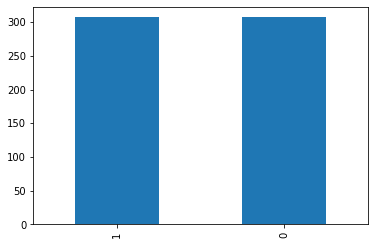

In [65]:
sm = SMOTE(random_state=123,ratio=1.0)
X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
pd.Series(Y_train_res).value_counts().plot.bar()

# logistic regression

In [120]:
log_model=LogisticRegression()
log_model.fit(X_train_res,Y_train_res)
Y_pred=log_model.predict(X_test)
accuracy_score(Y_test,Y_pred)

0.593103448275862

In [121]:
confusion_matrix(Y_test,Y_pred)

array([[30,  8],
       [51, 56]])

In [122]:
f1_score(Y_test,Y_pred)

0.654970760233918

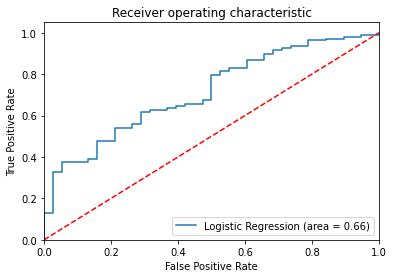

In [68]:
logit_roc_auc = roc_auc_score(Y_test, log_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, log_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Logistic Regression')

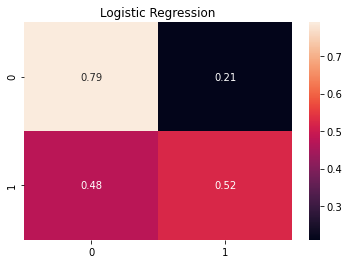

In [69]:
sns.heatmap(confusion_matrix(Y_test,Y_pred,normalize='true'),annot=True)
plt.title('Logistic Regression')

In [119]:
c=[1,100,0.1,0.75,10,5,0.01,0.001,0.00001]
accuracy=[]
f1=[]
for c_val in c:
  log=LogisticRegression(penalty='l2',max_iter=100,C=c_val,class_weight='balanced').fit(X_train,Y_train)
  Y_pred=log.predict(X_test)
  accuracy.append(accuracy_score(Y_test,Y_pred))
  f1.append(f1_score(Y_test,Y_pred))
performance=pd.DataFrame(({"accuracy":accuracy,"f1_score":f1,"C":c}))
performance

,accuracy,f1_score,C
0,0.586207,0.647059,1.00000
1,0.544828,0.607143,100.00000
2,0.579310,0.634731,0.10000
3,0.586207,0.647059,0.75000
4,0.565517,0.622754,10.00000
5,0.579310,0.639053,5.00000
6,0.600000,0.654762,0.01000
7,0.593103,0.650888,0.00100
8,0.524138,0.543046,0.00001


# KNN


In [70]:
knn=KNeighborsClassifier().fit(X_train_res,Y_train_res)
Y_pred=knn.predict(X_test)
accuracy_score(Y_test,Y_pred)

0.5517241379310345

Text(0.5, 1.0, 'Knn')

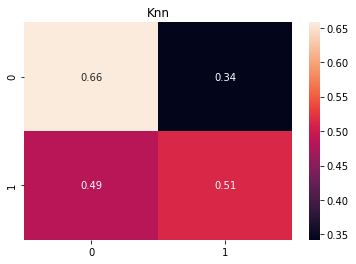

In [71]:
sns.heatmap(confusion_matrix(Y_test,Y_pred,normalize='true'),annot=True)
plt.title('Knn')

In [72]:
## parameter tuning
params={'n_neighbors':[3,5,7,1],'weights':['uniform', 'distance'] }
random=GridSearchCV(estimator=knn, param_grid=params,verbose=0,cv=5,refit=True,scoring='accuracy')
random.fit(X_train_res,Y_train_res)

#finding the best hyperparameters
print(random.best_params_)

{'n_neighbors': 1, 'weights': 'uniform'}


In [73]:
confusion_matrix(Y_test,Y_pred)

array([[25, 13],
       [52, 55]])

In [124]:
knn=KNeighborsClassifier(n_neighbors=1).fit(X_train_res,Y_train_res)
Y_pred=knn.predict(X_test)
accuracy_score(Y_test,Y_pred)

0.6758620689655173

In [125]:
f1_score(Y_test,Y_pred)

0.7661691542288557

In [75]:
neighbours=[1,3,5,11,13,7,9]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
params={'n_neighbors':neighbours,'weights':weights,'metric':metric}
random=GridSearchCV(estimator=knn, param_grid=params,verbose=0,refit=True,scoring='accuracy',cv=10)
random.fit(X_train_res,Y_train_res)
roc_auc_score(Y_test,Y_pred)
print(random.best_params_)

{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}


In [76]:
knn=KNeighborsClassifier(n_neighbors=1,metric='euclidean',weights='uniform').fit(X_train_res,Y_train_res)
Y_pred=knn.predict(X_test)
accuracy_score(Y_test,Y_pred)

0.6758620689655173

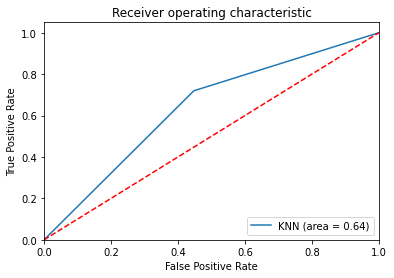

In [77]:
logit_roc_auc = roc_auc_score(Y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'KNN')

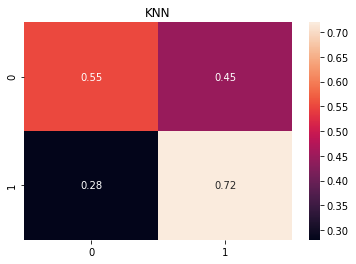

In [78]:
sns.heatmap(confusion_matrix(Y_test,Y_pred,normalize='true'),annot=True)
plt.title('KNN')

In [79]:
error_rate = []

for i in range(1,10):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_res,Y_train_res)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != Y_test))


Text(0, 0.5, 'Error Rate')

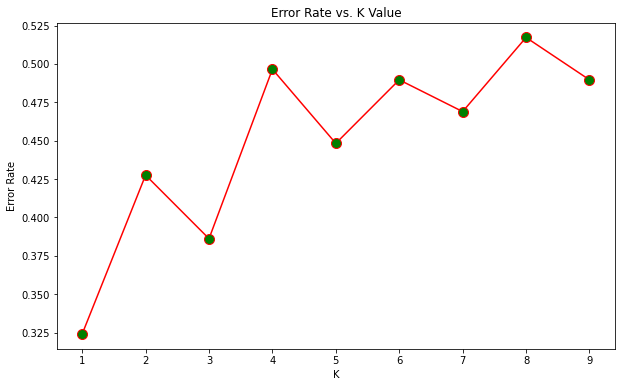

In [80]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),error_rate,color='red', linestyle='solid', marker='o',
         markerfacecolor='green', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

error rate as a function of the number of nearest neighbours, it is observed that k value of 1 or 3 has lowest error rate.

# Support Vector Machine

In [81]:
svm=SVC().fit(X_train_res,Y_train_res)
Y_pred=svm.predict(X_test)
accuracy_score(Y_test,Y_pred)

0.5655172413793104

Text(0.5, 1.0, 'SVC')

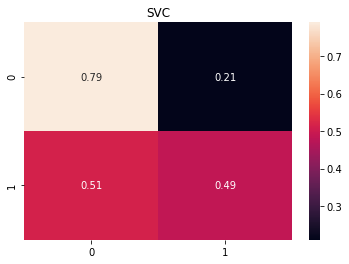

In [82]:
sns.heatmap(confusion_matrix(Y_test,Y_pred,normalize='true'),annot=True)
plt.title('SVC')

# Hyper Parameter-tuning

In [83]:
kernel=["rbf"]
c=[0.1,0.5,10,5,10,1,100]
gamma= [0.001,0.005, 0.01, 0.1, 1, 10,100,150]
params={'kernel':kernel,'C':c,'gamma':gamma}

In [84]:
# random=RandomizedSearchCV(estimator=svm, param_distributions=params,verbose=0,cv=5,refit=True,scoring='accuracy',random_state=0)
random=GridSearchCV(estimator=svm, param_grid=params,verbose=0,refit=True,scoring='accuracy',cv=10)
random.fit(X_train_res,Y_train_res)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.5, 10, 5, 10, 1, 100],
                         'gamma': [0.001, 0.005, 0.01, 0.1, 1, 10, 100, 150],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [85]:
#finding the best hyperparameters
print(random.best_params_)

{'C': 10, 'gamma': 10, 'kernel': 'rbf'}


In [126]:
svmc=SVC(C=10,kernel='rbf',gamma=10).fit(X_train_res,Y_train_res)
Y_pred=svmc.predict(X_test)
accuracy_score(Y_test,Y_pred)

0.7448275862068966

In [156]:
svmc=SVC(C=100,kernel='rbf',gamma=10).fit(X_train_res,Y_train_res)
Y_pred=svmc.predict(X_test)
accuracy_score(Y_test,Y_pred)

0.7448275862068966

In [127]:
f1_score(Y_test,Y_pred)

0.846473029045643

Text(0.5, 1.0, 'SVC')

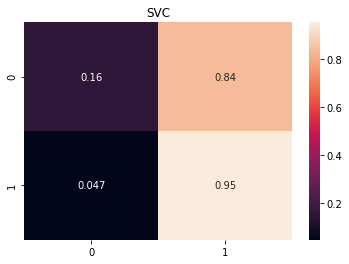

In [87]:
sns.heatmap(confusion_matrix(Y_test,Y_pred,normalize='true'),annot=True)
plt.title('SVC')

# Decision Tree Classifier

In [152]:
dt=DecisionTreeClassifier(random_state=0).fit(X_train_res,Y_train_res)
Y_pred=dt.predict(X_test)
accuracy_score(Y_test,Y_pred)

0.7103448275862069

In [153]:
f1_score(Y_test,Y_pred)

0.7941176470588236

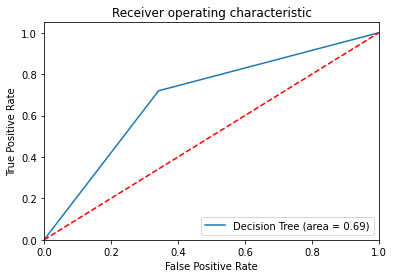

In [116]:
logit_roc_auc = roc_auc_score(Y_test, dt.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, dt.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Decision Tree')

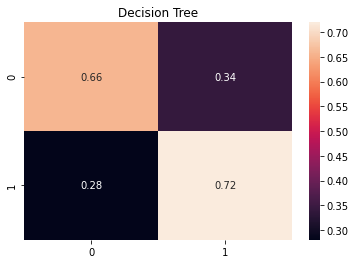

In [117]:
sns.heatmap(confusion_matrix(Y_test,Y_pred,normalize='true'),annot=True)
plt.title('Decision Tree')

# Random Forest

In [91]:
rf=RandomForestClassifier().fit(X_train_res,Y_train_res)
Y_pred=rf.predict(X_test)
accuracy_score(Y_test,Y_pred)

0.7034482758620689

In [92]:
rf.feature_importances_

array([0.10055356, 0.01480444, 0.13803899, 0.12476566, 0.12110437,
       0.13386908, 0.12141425, 0.08611296, 0.08167976, 0.07765692])

In [93]:
ft_set=pd.DataFrame({'Scores':rf.feature_importances_,"features":data.columns[:-1]})

### Hyper-parameter tuning


In [161]:
n_estimators = [8,9,10, 100, 1000,500,200]
max_features = ['sqrt', 'log2',4,7,9]
depth=[5,20,30]
grid = dict(n_estimators=n_estimators,max_features=max_features,max_depth=depth)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
random=RandomizedSearchCV(estimator=rf, param_distributions=grid,verbose=0,cv=5,refit=True,scoring='accuracy',random_state=0)
grid_result = random.fit(X_train_res,Y_train_res)
 
print(grid_result.best_params_)

{'n_estimators': 100, 'max_features': 'log2', 'max_depth': 20}


In [158]:
rndf=RandomForestClassifier(n_estimators=100,max_features='log2',max_depth=20,random_state=0).fit(X_train_res,Y_train_res)
Y_pred=rndf.predict(X_test)
accuracy_score(Y_test,Y_pred)

0.7172413793103448

In [151]:
f1_score(Y_test,Y_pred)

0.7960199004975125

### feature importances

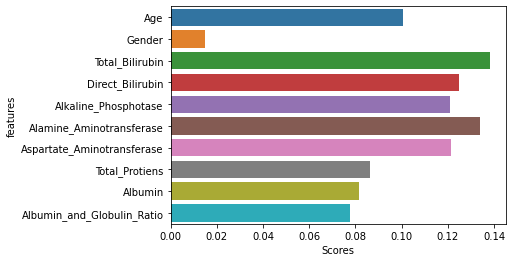

In [94]:
sns.barplot(x="Scores",y="features",data=ft_set)

Text(0.5, 1.0, 'RandomForest')

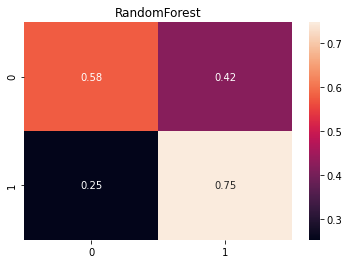

In [95]:
sns.heatmap(confusion_matrix(Y_test,Y_pred,normalize='true'),annot=True)
plt.title('RandomForest')

# Cross validation

In [96]:
from sklearn.model_selection import KFold,cross_val_score
kfold=KFold(n_splits=3,random_state=7)
lis=[log_model,svm,knn,dt,rf]
score=[]
for i in lis:
  result=cross_val_score(i,X,Y,cv=kfold,scoring='accuracy')
  score.append(result.mean())
# print(result.mean())
Performance=pd.DataFrame(data=score,index=["logistic_reg","Svmc","knn","dt","rndf"])
Performance


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the n

,0
logistic_reg,0.708117
Svmc,0.715026
knn,0.685665
dt,0.628670
rndf,0.699482


In [97]:
df=pd.DataFrame(data=Performance[Performance.columns].values.T,columns=Performance.index.values)

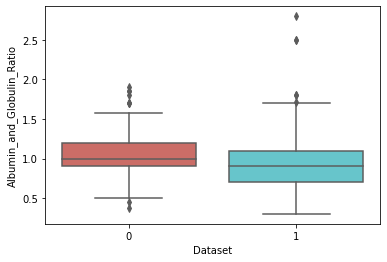

In [98]:
sns.boxplot(x='Dataset', y='Albumin_and_Globulin_Ratio', data=data, palette='hls')


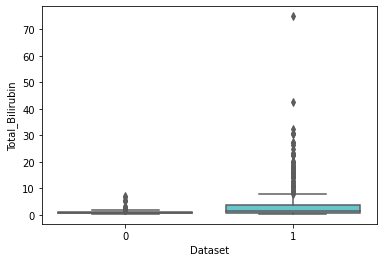

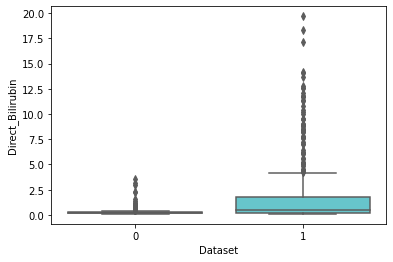

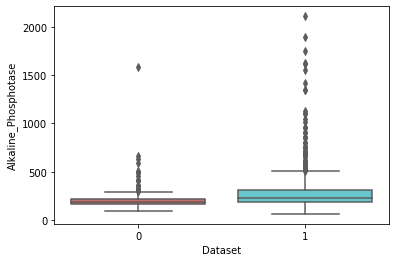

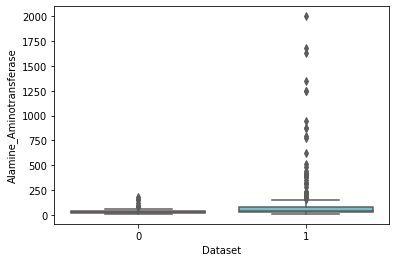

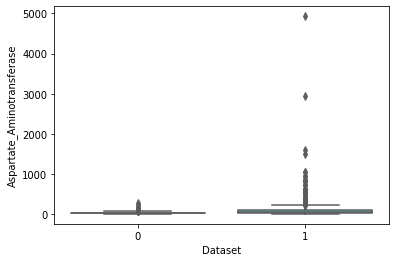

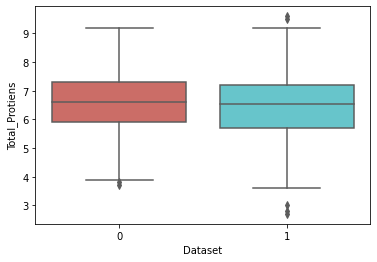

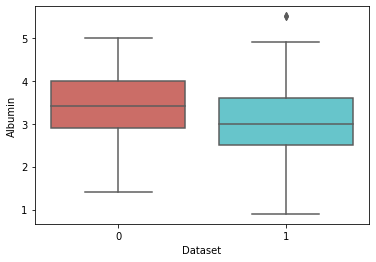

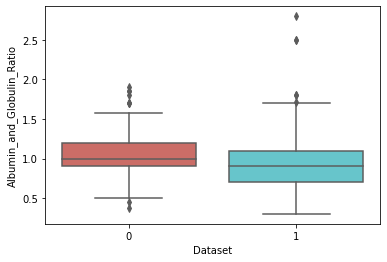

In [99]:
for i in data.columns[2:-1]:
  plt.figure()
  sns.boxplot(x='Dataset', y=i, data=data, palette='hls')


In [100]:
data.groupby('Dataset').mean().T


Dataset,0,1
Age,41.363636,46.144928
Gender,0.296970,0.219807
Total_Bilirubin,1.144848,4.180435
Direct_Bilirubin,0.396364,1.931643
Alkaline_Phosphotase,220.684848,319.536232
Alamine_Aminotransferase,33.836364,99.973430
Aspartate_Aminotransferase,40.763636,138.173913
Total_Protiens,6.539394,6.458696
Albumin,3.339394,3.058454
Albumin_and_Globulin_Ratio,1.029576,0.914179


from the representation of mean values of the attributes with respect to the target value-it is evident that for example **Aspartate_Aminotransferase** in higher amounts hints a disease possibility

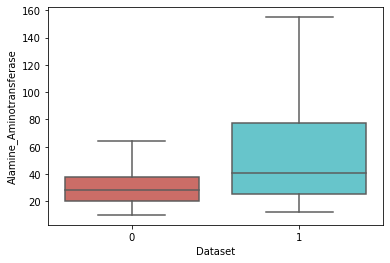

In [101]:
sns.boxplot(x='Dataset', y='Alamine_Aminotransferase', data=data, palette='hls',showfliers=False)

Its obvious that higher level of Alamina_Aminotransferace indicates a possibility of liver disease.

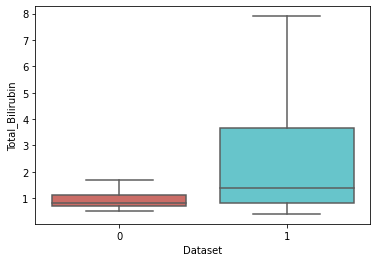

In [102]:
sns.boxplot(x='Dataset', y='Total_Bilirubin', data=data, palette='hls',showfliers=False)


A higher qantity of Total_Bilirubin is a direct estimator of presence of liver disease, bilirubin being a component of the blood.

#### Observations

it is evident that the Support Vector Classifier performs better than other training algorithmsconsidering the accuracy as the meterics, but the decision tree has a better ROC_AUC of value 0.68

###### Possible improvements
- Better methods to treat the missing values and outlier treatment can be applied to check its effect on performance of models.
- Feature selection techniques can also be experimented with.Also the stages of illness could prove to be of greater use to the physicians for medication. Neural networks can be experimented upon to produce satisfying results.
